## 🌐 Connect Colab to Google Drive

In [1]:
import os
#from google.colab import drive

# Mount Google Drive at /gdrive
#drive.mount('/gdrive')

# Change the current working directory to the specified path
#os.chdir('/gdrive/My Drive/[2024-2025] AN2DL/Homework 1')
print(os.getcwd())

/kaggle/working


## ⚙️ Import Libraries

In [2]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

from tensorflow import keras as tfk
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers as tfkl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.utils import shuffle
import keras_cv

import datetime
import cv2

import random

import seaborn as sns
import matplotlib.pyplot as plt

print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")

seed = 69
np.random.seed(seed)
tf.random.set_seed(seed)

mixed_precision.set_global_policy('mixed_float16')

Tensorflow version -> 2.16.1
Keras version -> 3.3.3


## ⏳ Load the Data

In [59]:
## On Kaggle
data = np.load('/kaggle/input/image-dataset/training_set.npz')
## On Colab
#data = np.load('training_set.npz')

X = data['images']
Y = data['labels']

# Data Cleaning

In [4]:
def plot_sample_images(X, Y, num_samples=8, col = 3):
    """
    Plot sample images from the dataset
    :param X: images
    :param Y: labels
    :param num_samples: number of samples to plot
    :param col: number of columns to plot
    """
    plt.figure(figsize=(15, 10))
    for i in range(num_samples*col):
        plt.subplot(col, num_samples, i + 1)
        plt.imshow(X[-i])
        plt.title(f'Label: {Y[-i]}')
        plt.axis('off')
    plt.show()

[[   0 1052]
 [   1 2381]
 [   2 1285]
 [   3 2226]
 [   4 1049]
 [   5 1393]
 [   6 2530]
 [   7 1843]]
Shape before removing meme images: (13759, 96, 96, 3)
Shape after removing meme images: (11959, 96, 96, 3)


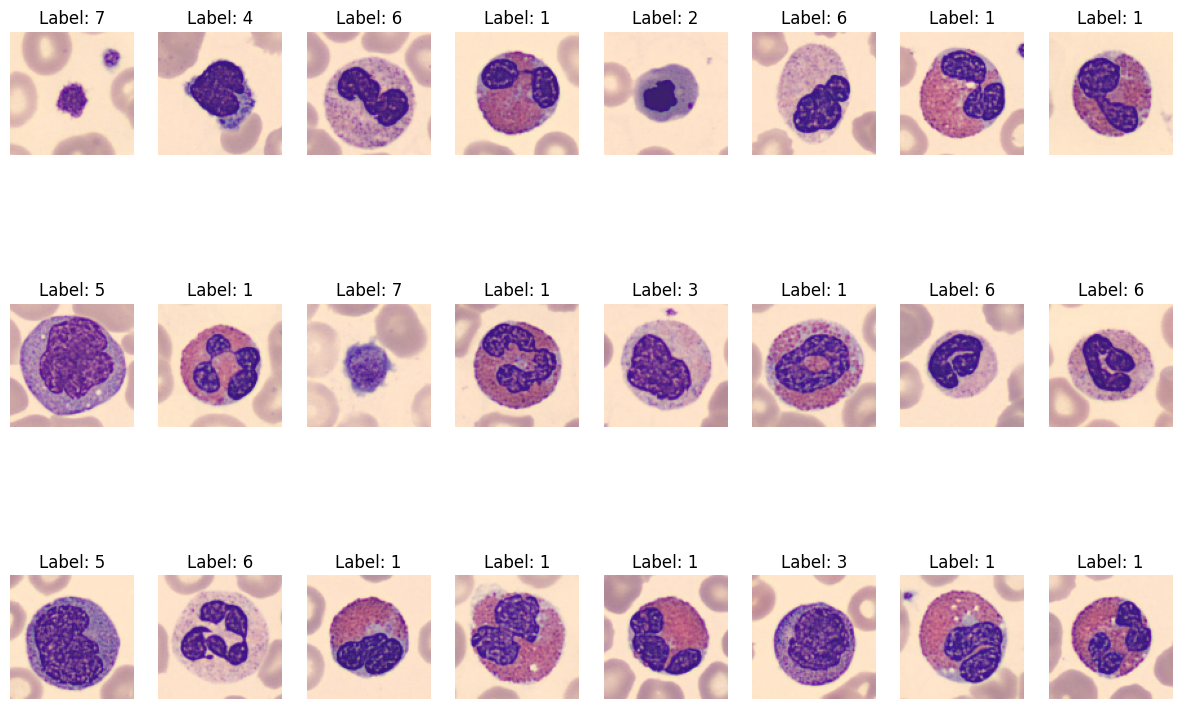

In [60]:
# Check if the dataset is balanced
unique, counts = np.unique(Y, return_counts=True)
print(np.asarray((unique, counts)).T)

# Remove meme images
print(f"Shape before removing meme images: {X.shape}")
meme_indices = range(11959, X.shape[0])
X = np.delete(X, meme_indices, axis=0)
Y = np.delete(Y, meme_indices, axis=0)
print(f"Shape after removing meme images: {X.shape}")

# Plot sample images from the training set
plot_sample_images(X, Y.flatten())

del unique, counts, meme_indices

# Creation of the Test Set - before Data Augmentation


In [61]:
X_train, val_X, y_train, val_Y = train_test_split(X, Y, random_state=seed, test_size=0.30, stratify=np.argmax(Y,axis=1))
del data, X, Y

# Training set Augmentation

#### Convex Augmentation

First, I create new samples of the same class, in a way that I balance the size of the class with most features. To do this, I interpolate the images I already have for each class.

In [62]:
def balance_dataset_with_blending(data, labels, number_img_per_class = None, verbose = 0):
    """
    Balance the dataset by blending images of underrepresented classes
    :param data: images
    :param labels: labels
    :param number_img_per_class: number of images per class
    :param verbose: verbosity level <-> 0: no print, 1: print some images
    :return: balanced dataset
    """

    # Find the maximum class size
    unique, counts = np.unique(labels, return_counts=True)
    class_counts = dict(zip(unique, counts))
    print(f"Number of classes: {len(unique)}")
    print(f"Number of images per class: {class_counts}")
    max_class_size = 0
    if number_img_per_class is None:
        max_class_size = max(class_counts.values())
    else:
        max_class_size = number_img_per_class
    print(f"Maximum class size: {max_class_size}")

    # Initialize new dataset lists
    X_balanced = []
    Y_balanced = []

    # Loop over each class to balance
    for class_label in unique:
        # Filter images of the current class
        class_indices = np.where(labels == class_label)[0]
        class_images = data[class_indices]

        # Add original images of the class to the balanced dataset
        X_balanced.extend(class_images)
        Y_balanced.extend([class_label] * len(class_images))

        # Calculate how many more images are needed to reach max_class_size
        num_images_needed = max_class_size - len(class_images)

        # Generate blended images if the class is underrepresented
        while num_images_needed > 0:
            # Randomly pick two images to blend
            img1, img2 = random.choices(class_images, k=2)

            # Blend images with 50-50 ratio (you can vary this ratio)
            alpha = 0.2
            blended_img = cv2.addWeighted(img1, alpha, img2, 1 - alpha, 0)

            # Append the blended image to the dataset
            X_balanced.append(blended_img)
            Y_balanced.append(class_label)

            num_images_needed -= 1

    # Convert lists back to numpy arrays
    X_balanced = np.array(X_balanced)
    Y_balanced = np.array(Y_balanced)

    return X_balanced, Y_balanced

#### Random Augmentation

In [63]:
def CustomRandAugment(x, num_augmentations = 4, geometrical=False):
    if geometrical:
        maxIndex=12
    else:
        maxIndex=10
        
    # Check value range 
    value_range=(np.min(x), np.max(x))

    x=tfkl.RandomFlip("horizontal_and_vertical")(x)
    x=tfkl.RandomRotation(1, value_range=value_range)(x) # 1 set it all 360°, value range is of the pixels
    for N in range(1,num_augmentations):
        i=np.random.randint(maxIndex)
        match i:
            case 1:
                x=keras_cv.layers.AutoContrast([0, 255])(x)
            case 2:
                x=keras_cv.layers.RandomHue((0.4, 0.4),[np.min(value_range), np.max(value_range)])(x)
            case 3:
                x=keras_cv.layers.ChannelShuffle(groups=3)(x)
            case 4:
                x=keras_cv.layers.GridMask(ratio_factor=(0, 0.4),rotation_factor=0.15)(x) #non mi convince (mette dei quadrati neri sulla foto)
            case 5:
                x=keras_cv.layers.RandomChannelShift(value_range=value_range,factor=0.5)(x)
            case 6:
                x=keras_cv.layers.RandomColorDegeneration(factor=0.8)(x)
            case 7:
                x=keras_cv.layers.RandomCutout(height_factor=(0.1, 0.2), width_factor=(0.1, 0.2), fill_mode="gaussian_noise")(x)
            case 8:
                x=keras_cv.layers.RandomSaturation(factor=0.8)(x)
            case 9:
                x=keras_cv.layers.Solarization(value_range=value_range,threshold_factor=200)(x)
            case 10:
                x=keras_cv.layers.Equalization(value_range=value_range, bins=255)(x)
            case 11:
                x=keras_cv.layers.JitteredResize(target_size=(96,96),scale_factor=(0.2,0.9))(x)
            case 12:
                x=keras_cv.layers.RandomShear(x_factor=0.3,y_factor=0.3,interpolation="bilinear",fill_mode="reflect",fill_value=0.0,bounding_box_format=None)(x)
    return x

def augment_img(img, augmentation):
    """
    Augment a single image using the specified augmentation pipeline.
    :param img: image to augment
    :param augmentation: augmentation pipeline
    :return: augmented image with values clipped between 0 and 1
    """
    augmented_img = CustomRandAugment(x=img, geometrical=False)
    return  augmented_img.numpy().astype(np.float32)

def augment_data(data, labels, augmentation,  number_img = 1000):
    """
    Augment a dataset using the specified augmentation pipeline and return the augmented data concatenated with the original data.
    :param data: images
    :param labels: labels
    :param augmentation: augmentation pipeline
    :param number_img: number of desired images per classes
    """
    image_to_generate = max(number_img - len(data), 0)
    
    # Pre-calculate indices for sampling
    indices = np.random.randint(0, len(data), size=image_to_generate)
    
    # Initialize arrays for augmented data
    data_augmented = np.zeros((image_to_generate, *data.shape[1:]), dtype=data.dtype)
    labels_augmented = np.zeros((image_to_generate, *labels.shape[1:]), dtype=labels.dtype)

    # Apply augmentation in batches for efficiency
    batch_size = 64
    for i in range(0, image_to_generate, batch_size):
        batch_indices = indices[i:i+batch_size]
        batch_images = data[batch_indices]
        
        print(f"\rUpdate the class percentage {100*i/image_to_generate} %", end = "")
        
        # Apply augmentation to the batch
        augmented_batch = np.array([
            augment_img(img, augmentation) for img in batch_images
        ])
        
        # Store the augmented batch
        data_augmented[i:i+len(batch_indices)] = augmented_batch
        labels_augmented[i:i+len(batch_indices)] = labels[batch_indices]

    return np.concatenate((data, data_augmented), axis=0), np.concatenate((labels, labels_augmented), axis=0)

def class_balancing(data, labels, augmentation, number_img_per_class = 10, verbose = 0):
    """
    Function to balance class distribution in the training data with augmentation.
    :param data: images
    :param labels: labels
    :param augmentation: augmentation pipeline
    :param number_img_per_class: number of images per class
    :param verbose: verbosity level <-> 0: no print, 1: print some images
    :return: balanced dataset
    """

    # Count the number of images per class
    unique_classes, counts = np.unique(labels, return_counts=True)
    print(f"Number of classes: {len(unique_classes)}")
    print(f"Number of images per class: {counts}")
    number_aug = np.maximum(number_img_per_class - counts, 0)
    print(f"Number of augmented images per class: {number_aug}\n")

    # Preallocate memory for the balanced dataset
    data_balanced = np.zeros((number_img_per_class * len(unique_classes), *data.shape[1:]), dtype=data.dtype)
    labels_balanced = np.zeros((number_img_per_class * len(unique_classes), *labels.shape[1:]), dtype=labels.dtype)

    for i, c in enumerate(unique_classes):
        # Filter images of the current class
        print(f"Augmenting class {c}")
        class_indices = np.where(labels == c)[0]
        class_data = data[class_indices]
        class_labels = labels[class_indices]

        # Augment the data
        augmented_data, augmented_labels = augment_data(class_data, class_labels, augmentation, number_img_per_class)

        # Display some augmented images if verbose
        if verbose:
            plot_sample_images(augmented_data, augmented_labels)

        # Add the augmented data to the balanced dataset
        start = i * number_img_per_class
        end = (i + 1) * number_img_per_class
        data_balanced[start:end] = augmented_data
        labels_balanced[start:end] = augmented_labels

    return data_balanced, labels_balanced


def display_class_distribution(xxxx, title="Class Distribution"):
    """
    Display the distribution of classes in a dataset.
    :param xxxx: labels
    :param title: plot title
    """
    print(f"{title}:")
    unique, counts = np.unique(xxxx, return_counts=True)
    print(np.asarray((unique, counts)).T)

#### Data Augmentation Pipeline

In [64]:
def augmentation_pipeline(X_train, y_train, balanced = True, random_augmentation = False, number = 3000, verbose = 0):
    """
    Function to create the augmentation pipeline.
    :param X_train: images
    :param y_train: labels
    :param balanced: boolean to balance the dataset with blending
    :param random_augmentation: boolean to augment the dataset with random tecniques
    :param number: number of images per class
        :param verbose: verbosity level <-> 0: no print, 1: print some images after every step
    :return: augmented dataset with images concatenated with the original images and clipped between 0 and 1
    """
    if balanced :
        # Balance the dataset
        if not random_augmentation:
            X_balanced, Y_balanced = balance_dataset_with_blending(X_train, y_train.flatten(), number_img_per_class = number)
        else:
            X_balanced, Y_balanced = balance_dataset_with_blending(X_train, y_train.flatten())

        # Add a channel dimension
        Y_balanced= np.expand_dims(Y_balanced, axis = 1)

        # Verify new class distribution
        unique_balanced, counts_balanced = np.unique(Y_balanced, return_counts=True)
        print("Balanced Class Distribution:", np.asarray((unique_balanced, counts_balanced)).T)

        # Plot sample images from the balanced dataset
        if verbose:
            plot_sample_images(X_balanced, Y_balanced)

        # Save the balanced dataset
        X_train, y_train = X_balanced, Y_balanced

        del X_balanced, Y_balanced

    if random_augmentation:

        augmentation = tfk.Sequential([
            tfkl.RandomFlip("horizontal_and_vertical"),
            tfkl.RandomRotation(1), # 1 set it all 360°, value range is of the pixels
            tfkl.RandomBrightness(0.5, value_range=(0,1)),
            tfkl.RandomContrast(0.8),
            
        ], name='Augmentation')
        
        # Augment the dataset
        X_augmented, y_augmented = class_balancing(X_train, y_train, augmentation, number, verbose = verbose)
        # Display the class distribution
        display_class_distribution(y_augmented, "Augmented Class Distribution")
        # Save the augmented dataset
        X_train, y_train = X_augmented, y_augmented
        # Normalize the input
        X_train = X_train/255
        del X_augmented, y_augmented

    return X_train, y_train

Number of classes: 8
Number of images per class: [ 585 1537  765 1409  583  705 1638 1149]
Number of augmented images per class: [1415  463 1235  591 1417 1295  362  851]

Augmenting class 0
Update the class percentage 0.0%

/tmp/ipykernel_30/3656590831.py:82: RuntimeWarning: invalid value encountered in cast
  data_augmented[i:i+len(batch_indices)] = augmented_batch


Update the class percentage 99.50530035335689%%

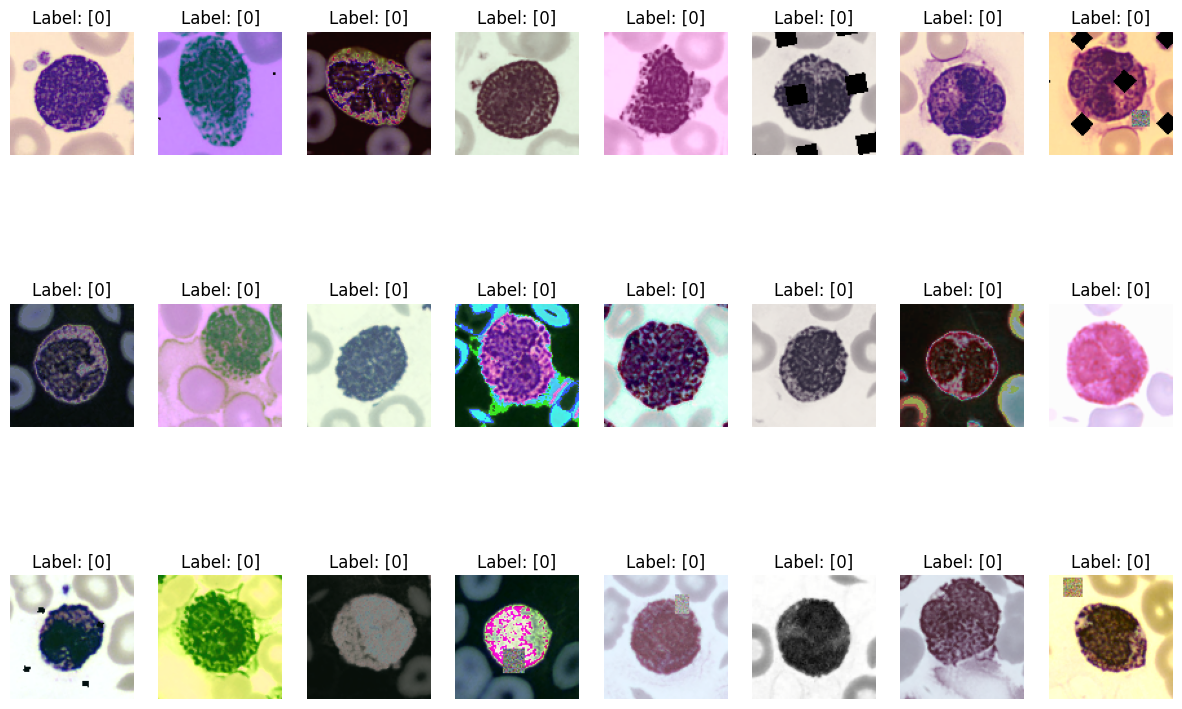

Augmenting class 1
Update the class percentage 96.76025917926566%%

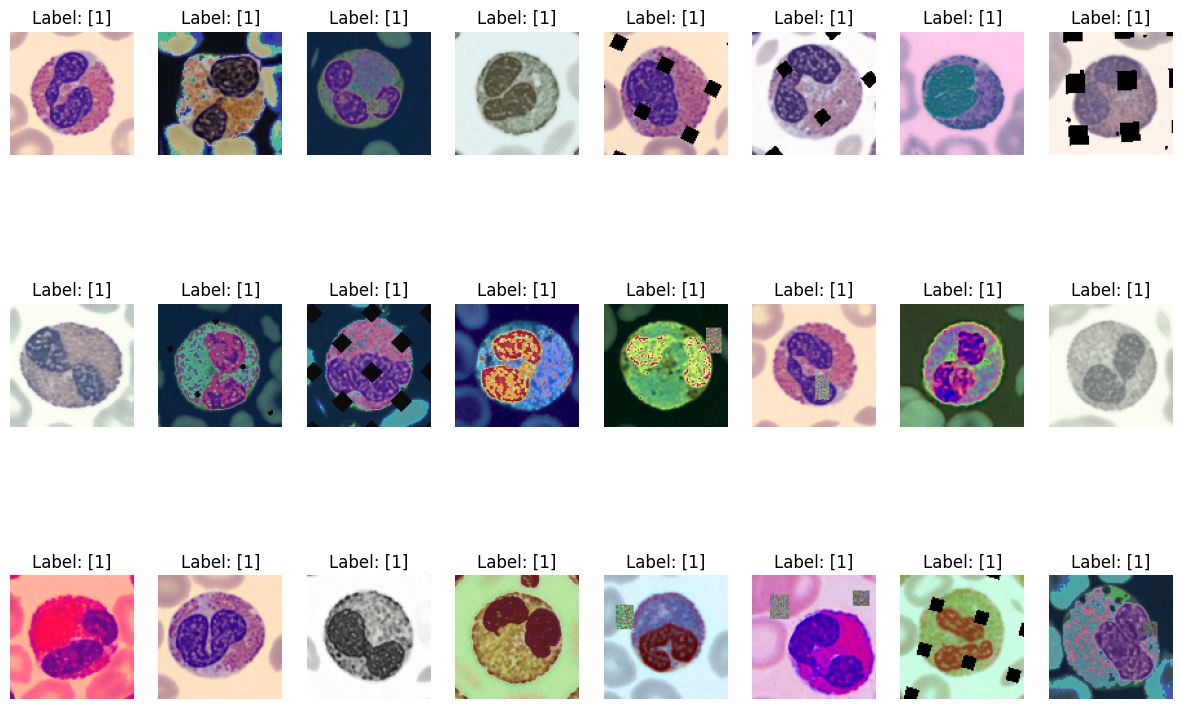

Augmenting class 2
Update the class percentage 82.91497975708502%%

KeyboardInterrupt: 

In [65]:
# Augment the dataset
X_train, y_train = augmentation_pipeline(X_train, y_train, balanced = False, random_augmentation = True, number = 2000, verbose = 1)

In [13]:
# One-hot encode the labels of the training
y_train = tfk.utils.to_categorical(y_train)
val_Y = tfk.utils.to_categorical(val_Y)

# Transfer Learning

## Model parameters

In [14]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]

print(f"input_shape: {input_shape}")
print(f"output_shape: {output_shape}")

input_shape: (96, 96, 3)
output_shape: 8


## Callbacks

In [15]:
# Define the patience value for early stopping
patience = 15

# Create an EarlyStopping callback
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

# Store the callback in a list
callbacks = [early_stopping]

checkpoint_folder = 'checkpoints'
def setup_checkpoint_folders(start_time, callbacks, checkpoint_folder):
    """
    Function to setup the checkpoint folders and callbacks.
    :param start_time: start time of the training
    :param callbacks: list of callbacks
    :param checkpoint_folder: folder to store the checkpoints
    :return: list of callbacks
    """

    # Add ModelCheckpoint callback for this fold
    if not os.path.exists(checkpoint_folder):
        os.makedirs(checkpoint_folder)

    starting_time_folder = f'{start_time}'
    checkpoint_folder = f'{checkpoint_folder}'
    if not os.path.exists(checkpoint_folder):
        os.makedirs(checkpoint_folder)
    checkpoint_path = f'{checkpoint_folder}/best_model.keras'

    checkpoint = tfk.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    )

    # Add the checkpoint callback to the list of callbacks
    callbacks.append(checkpoint)

    return callbacks


In [39]:
# Load the Xception model without the top layers (for feature extraction)
pretrained_base = tfk.applications.Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

#pretrained_base.summary()

# Possible augmentation
augmentation = tfk.Sequential([
            tfkl.RandomFlip("horizontal_and_vertical"),
            tfkl.RandomRotation(1), # 1 set it all 360°, value range is of the pixels
            tfkl.RandomBrightness(0.1, value_range=(0,1)),
            tfkl.RandomContrast(0.1),
        ], name='Augmentation')

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Model Creation

In [40]:
def create_model(pretrained_model, input_shape=input_shape, output_shape=output_shape, augmentation = augmentation, do_augmentation= False,
                lr=1e-3, fine_tuning=False, freeze_layers=60):
    """
    Function to create a model with the specified pretrained model and input/output shapes.
    :param pretrained_model: pretrained model
    :param input_shape: input shape
    :param output_shape: output shape
    :param augmentation: augmentation pipeline
    :param do_augmentation: boolean to do augmentation at start
    :param lr: Learning rate for transfer learning
    :param fine_tuning: boolean to fine tune the model
    :param freeze_layers: Number of initial layers to freeze

    :return: compiled model
    """

    if fine_tuning:
        # Unfreeze the pretrained model
        pretrained_model.trainable = True

        # Freeze the first `freeze_layers` layers and selectively unfreeze specific types
        for i, layer in enumerate(pretrained_model.layers):
            if i < freeze_layers:  # Freeze the first `freeze_layers`
                layer.trainable = False
            elif isinstance(layer, tfkl.Conv2D) or isinstance(layer, tfkl.DepthwiseConv2D) or isinstance(layer, tfkl.SeparableConv2D):
                layer.trainable = True  # Unfreeze Conv2D and DepthwiseConv2D
            elif isinstance(layer, tfkl.BatchNormalization):
                layer.trainable = False  # Keep BatchNormalization frozen
            else:
                layer.trainable = False  # Freeze other layers (e.g., pooling)
    else:
        pretrained_model.trainable = False

    # Define the input layer with your custom input size
    inputs = tfkl.Input(shape=input_shape, name='input_layer')

    # Use tfkl.Resizing to resize input to 299x299 (CHANGE IF DIFFERENT PRETRAINED MODEL!!!)
    x = tfkl.Resizing(height=224, width=224, interpolation="bilinear")(inputs)

    # Augmentation
    if do_augmentation:
        x = augmentation(x)
        x = tfkl.BatchNormalization()(x)

    # Pass the upsampled inputs through the Xception base
    x = pretrained_model(x)
    
    # Apply self-attention
    num_heads = 8
    attention_layer = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=128)
    x = attention_layer(query=x, key=x, value=x)

    # Add dropout for regularization
    x = tfkl.Dropout(0.3, name='dropout')(x)

    # Add a global average pooling layer to reduce spatial dimensions
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    # Add batch normalization before the dense layer
    x = tfkl.BatchNormalization(name='batch_norm')(x)

    # Add a dense layer for final output
    x = tfkl.Dense(output_shape, name='dense', kernel_regularizer=tfk.regularizers.l2(0.02))(x)

    # Apply softmax activation for classification
    outputs = tfkl.Activation('softmax', name='softmax')(x)

    # Define the model
    model = tfk.Model(inputs=inputs, outputs=outputs, name='NASNet_transfer_learning')

    # Compile the model
    model.compile(
        loss=tfk.losses.CategoricalCrossentropy(),
        optimizer=tfk.optimizers.Adam(learning_rate = lr),
        metrics=['accuracy']
    )

    # Summary of the model
    #model.summary(expand_nested=True)

    return model



In [41]:
transfer_learning_model = create_model(
    pretrained_model=pretrained_base,
    input_shape=input_shape,
    output_shape=output_shape,
    augmentation=augmentation,
    do_augmentation=False,
    lr=1e-3,
    fine_tuning=False)

## Fit the model

Check if training set is between 0 and 1

In [19]:
print(f"Minimum pixel value: {np.min(X_train)}")
print(f"Maximum pixel value: {np.max(X_train)}")
print(f"Type: {X_train.dtype} ")

print(f"shape of train_Y:{y_train.shape}")

Minimum pixel value: 0.0
Maximum pixel value: 1.0
Type: float64 
shape of train_Y:(32000, 8)


Check if validation set is between 0 and 1

In [20]:
print(f"Preprocessing validation set for Xception")
if np.max(val_X) > 1:
    X_val = val_X / 255
else:
    X_val = val_X 
print(f"Minimum pixel value: {np.min(X_val)}")
print(f"Maximum pixel value: {np.max(X_val)}")
print(f"Type: {X_val.dtype} ")

print(f"shape of val_Y:{val_Y.shape}")
print(f"shape of val_Y:{X_val.shape}")

Preprocessing validation set for Xception
Minimum pixel value: 0.0
Maximum pixel value: 1.0
Type: float32 
shape of val_Y:(7176, 8)
shape of val_Y:(7176, 96, 96, 3)


In [42]:
batch_size = 256
epochs = 100

#start_time = datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")

callbacks = setup_checkpoint_folders(start_time, callbacks, checkpoint_folder)

print(f'Starting training at {start_time}')

# Train the model
pretrained_model_history = transfer_learning_model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, val_Y),
    callbacks=callbacks
).history

Starting training at 2024-11-18_17:36:55
Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.5881 - loss: 3.0370
Epoch 1: val_accuracy did not improve from 0.93032

Epoch 1: val_accuracy improved from 0.58710 to 0.88824, saving model to checkpoints/best_model.keras

Epoch 1: val_accuracy improved from -inf to 0.88824, saving model to checkpoints/best_model.keras

Epoch 1: val_accuracy improved from -inf to 0.88824, saving model to checkpoints/best_model.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 119s 640ms/step - accuracy: 0.5892 - loss: 3.0270 - val_accuracy: 0.8882 - val_loss: 0.5151
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8736 - loss: 0.5162
Epoch 2: val_accuracy did not improve from 0.93032

Epoch 2: val_accuracy improved from 0.88824 to 0.90245, saving model to checkpoints/best_model.keras

Epoch 2: val_accuracy improved from 0.88824 to 0.90245, saving model to checkpoints/best_model.keras

Epoch 2: val_accuracy improved from 0.88824 to 0.9024

Mean validation accuracy: 0.8694723129272461 std. dev: 0.04095930397983879


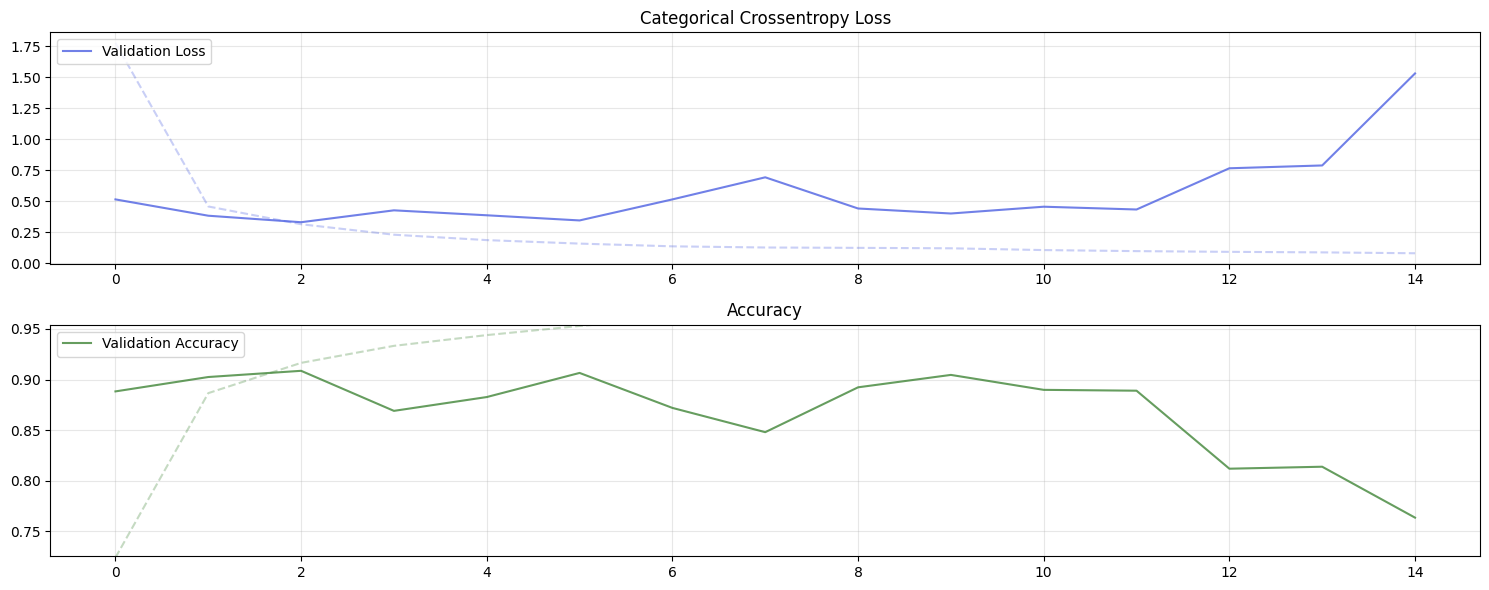

In [43]:
 # Mean Validation accuracy and std dev. 
print(f"Mean validation accuracy: {np.mean(pretrained_model_history['val_accuracy'])} std. dev: {np.std(pretrained_model_history['val_accuracy'])}")

# Plotting Training and Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot categorical cross-entropy loss for both Transfer Learning and Fine-Tuning stages
ax1.plot(pretrained_model_history['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(pretrained_model_history['val_loss'], label='Validation Loss', alpha=0.8, color='#4D61E2')
ax1.set_title('Categorical Crossentropy Loss')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both Transfer Learning and Fine-Tuning stages
ax2.plot(pretrained_model_history['accuracy'], alpha=0.3, color='#408537', linestyle='--')
ax2.plot(pretrained_model_history['val_accuracy'], label='Validation Accuracy', alpha=0.8, color='#408537')
ax2.set_title('Accuracy')
ax2.set_ylim([min(pretrained_model_history['val_accuracy']) * 0.95, max(pretrained_model_history['val_accuracy']) * 1.05])
ax2.legend(loc='upper left')
ax2.grid(alpha=0.3)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [44]:
del pretrained_model_history

## Save weights

In [45]:
# move best weight of this train into weights.keras
temp = f"checkpoints"
best_model_path = os.path.join(temp, 'best_model.keras')
destination_path = './weights.keras'

print(f"File path: {best_model_path}")

try:
    # Attempt to move the file
    os.rename(best_model_path, destination_path)

    # Check if the file was successfully moved
    if os.path.exists(destination_path):
        print(f"File '{best_model_path}' successfully moved to '{destination_path}'")
    else:
        raise FileNotFoundError(f"File '{best_model_path}' not found in destination")
except FileNotFoundError:
    print(f"Error: Source file '{best_model_path}' not found.")
except PermissionError:
    print(f"Error: Permission denied to move file '{best_model_path}'.")
except Exception as e:
    print(f"An unexpected error occurred: {str(e)}")

File path: checkpoints/best_model.keras
File 'checkpoints/best_model.keras' successfully moved to './weights.keras'


## Fine Tuning

In [25]:
fine_tune_model = create_model(
    pretrained_model=pretrained_base,
    input_shape=input_shape,
    output_shape=output_shape,
    augmentation=augmentation,
    do_augmentation=False,
    lr=1e-4,
    fine_tuning=True,
    freeze_layers=60)


# Ensure the weights from the transfer learning phase are used
fine_tune_model.set_weights(transfer_learning_model.get_weights())

Fit the model

In [ ]:
# Train the fine-tuned model
fine_tune_history = fine_tune_model.fit(
    x=X_train,
    y=y_train,
    batch_size=256,
    epochs=50,
    validation_data=(X_val, val_Y),
    callbacks=callbacks
).history


In [27]:
# move best weight of this train into weights.keras
temp = f"checkpoints"
best_model_path = os.path.join(temp, 'best_model.keras')
destination_path = './weights.keras'

print(f"File path: {best_model_path}")

try:
    # Attempt to move the file
    os.rename(best_model_path, destination_path)

    # Check if the file was successfully moved
    if os.path.exists(destination_path):
        print(f"File '{best_model_path}' successfully moved to '{destination_path}'")
    else:
        raise FileNotFoundError(f"File '{best_model_path}' not found in destination")
except FileNotFoundError:
    print(f"Error: Source file '{best_model_path}' not found.")
except PermissionError:
    print(f"Error: Permission denied to move file '{best_model_path}'.")
except Exception as e:
    print(f"An unexpected error occurred: {str(e)}")

File path: checkpoints/best_model.keras
File 'checkpoints/best_model.keras' successfully moved to './weights.keras'


NameError: name 'fine_tune_history' is not defined

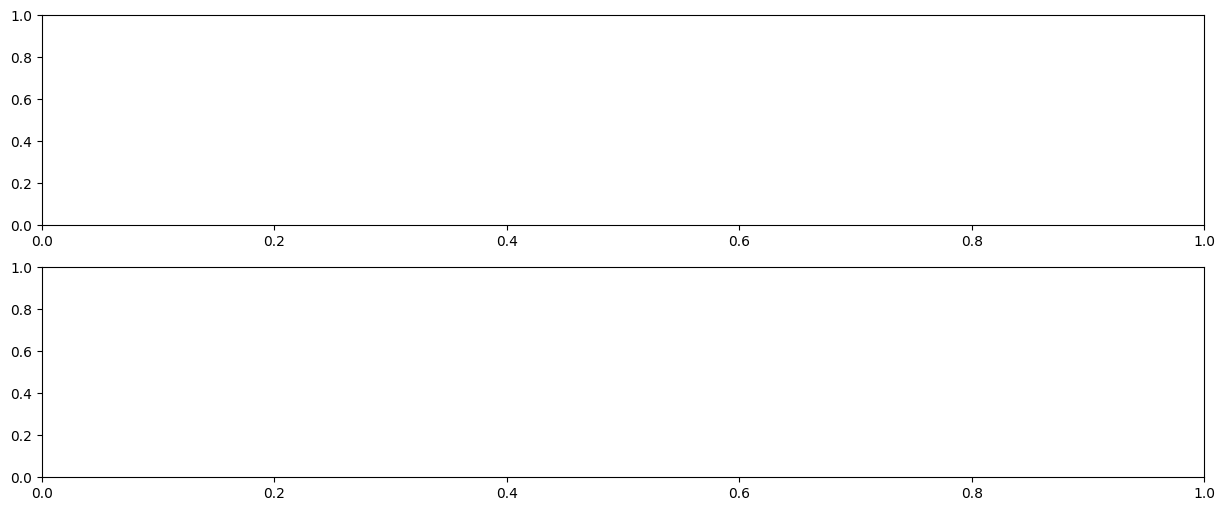

In [28]:
# Plotting Training and Fine-Tuning Loss and Accuracy
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 6))

# Plot categorical cross-entropy loss for both Transfer Learning and Fine-Tuning stages
ax1.plot(fine_tune_history['loss'], alpha=0.3, color='#4D61E2', linestyle='--')
ax1.plot(fine_tune_history['val_loss'], label='Validation Loss', alpha=0.8, color='#4D61E2')
ax1.set_title('Categorical Crossentropy Loss')
ax1.legend(loc='upper left')
ax1.grid(alpha=0.3)

# Plot accuracy for both Transfer Learning and Fine-Tuning stages
ax2.plot(fine_tune_history['accuracy'], alpha=0.3, color='#408537', linestyle='--')
ax2.plot(fine_tune_history['val_accuracy'], label='Validation Accuracy', alpha=0.8, color='#408537')
ax2.set_title('Accuracy')
ax2.set_ylim([min(fine_tune_history['val_accuracy']) * 0.95, max(fine_tune_history['val_accuracy']) * 1.05])
ax2.legend(loc='upper left')
ax2.grid(alpha=0.3)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

# Submission

In [1]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        X = X.astype(np.float32) / 255.0
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [2]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

  adding: model.py (deflated 55%)
  adding: weights.keras (deflated 7%)
